Imports & basic setup

In [1]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


Download VADER lexicon

In [2]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\filimon.hailemariam\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package vader_lexicon is already up-to-date!


Create a small sample review dataset

In [3]:
# Cell 4: Create a synthetic dataset of bank app reviews

data = [
    {"review_text": "Exceptional product, very easy to use and fast.", "rating": 5},
    {"review_text": "The app is impressive and smooth. Great job Dashen Bank!", "rating": 5},
    {"review_text": "Good app but sometimes it is slow.", "rating": 3},
    {"review_text": "Bill payment options are limited, please add more services.", "rating": 2},
    {"review_text": "It is really slow and always crashing. Very frustrating!", "rating": 1},
    {"review_text": "Always updating, bad stability, I don't like it.", "rating": 1},
    {"review_text": "With the super app everything I need is just a tap away.", "rating": 5},
    {"review_text": "It's okay, nothing special but it works.", "rating": 3},
    {"review_text": "I disabled developer options but it still doesn't work.", "rating": 1},
    {"review_text": "Clean design, user friendly and reliable.", "rating": 4},
]

df = pd.DataFrame(data)
df.head()


,review_text,rating
0,"Exceptional product, very easy to use and fast.",5
1,The app is impressive and smooth. Great job Da...,5
2,Good app but sometimes it is slow.,3
3,"Bill payment options are limited, please add m...",2
4,It is really slow and always crashing. Very fr...,1


Map star ratings → sentiment labels (for ML)

In [4]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_label"] = df["rating"].apply(rating_to_label)
df


,review_text,rating,sentiment_label
0,"Exceptional product, very easy to use and fast.",5,positive
1,The app is impressive and smooth. Great job Da...,5,positive
2,Good app but sometimes it is slow.,3,neutral
3,"Bill payment options are limited, please add m...",2,negative
4,It is really slow and always crashing. Very fr...,1,negative
5,"Always updating, bad stability, I don't like it.",1,negative
6,With the super app everything I need is just a...,5,positive
7,"It's okay, nothing special but it works.",3,neutral
8,I disabled developer options but it still does...,1,negative
9,"Clean design, user friendly and reliable.",4,positive


1,Frequency-Based vs TF-IDF

Basic text cleaning

In [5]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,"Exceptional product, very easy to use and fast.","exceptional product, very easy to use and fast."
1,The app is impressive and smooth. Great job Da...,the app is impressive and smooth. great job da...
2,Good app but sometimes it is slow.,good app but sometimes it is slow.
3,"Bill payment options are limited, please add m...","bill payment options are limited, please add m..."
4,It is really slow and always crashing. Very fr...,it is really slow and always crashing. very fr...
5,"Always updating, bad stability, I don't like it.","always updating, bad stability, i don't like it."
6,With the super app everything I need is just a...,with the super app everything i need is just a...
7,"It's okay, nothing special but it works.","it's okay, nothing special but it works."
8,I disabled developer options but it still does...,i disabled developer options but it still does...
9,"Clean design, user friendly and reliable.","clean design, user friendly and reliable."


Frequency-based representation (Bag of Words)

In [6]:
# Cell 7: Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
1,app,3
27,options,2
33,slow,2
0,add,1
4,bank,1
5,clean,1
6,crashing,1
7,dashen,1
8,design,1
9,developer,1


Visualize top frequent words

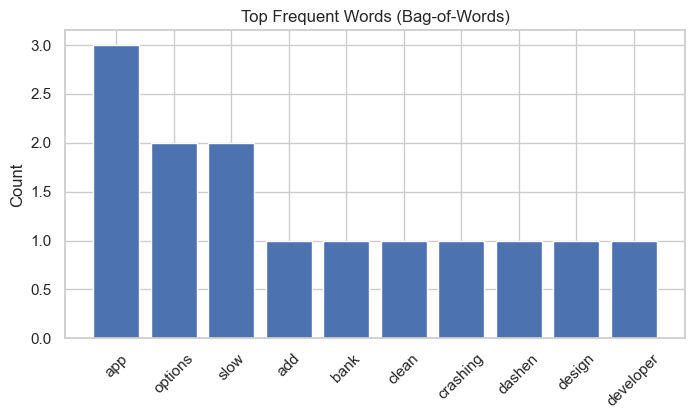

In [7]:
# Cell 8: Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [8]:
# Cell 9: TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
1,app,0.109914
33,slow,0.100410
27,options,0.078235
18,good,0.066288
26,okay,0.057735
35,special,0.057735
43,works,0.057735
30,really,0.051829
17,frustrating,0.051829
6,crashing,0.051829


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 Interpretation of our output

“app” (0.1099) → highly important theme

“slow”, “crashing”, “frustrating” → key negative issues

“options”, “good”, “works” → meaningful topics in reviews

Compare TF-IDF vs raw frequency

In [9]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
1,app,3
27,options,2
33,slow,2
0,add,1
4,bank,1
5,clean,1
6,crashing,1
7,dashen,1
8,design,1
9,developer,1



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
1,app,0.109914
33,slow,0.100410
27,options,0.078235
18,good,0.066288
26,okay,0.057735
35,special,0.057735
43,works,0.057735
30,really,0.051829
17,frustrating,0.051829
6,crashing,0.051829


Topic Modeling (LDA)

In [20]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [25]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filimon.hailemariam\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,"exceptional product, very easy to use and fast.","[exceptional, product,, very, easy, to, use, a...","[exceptional, product,, easy, use, fast.]"
1,the app is impressive and smooth. great job da...,"[the, app, is, impressive, and, smooth., great...","[app, impressive, smooth., great, job, dashen,..."
2,good app but sometimes it is slow.,"[good, app, but, sometimes, it, is, slow.]","[good, app, sometimes, slow.]"
3,"bill payment options are limited, please add m...","[bill, payment, options, are, limited,, please...","[bill, payment, options, limited,, please, add..."
4,it is really slow and always crashing. very fr...,"[it, is, really, slow, and, always, crashing.,...","[really, slow, always, crashing., frustrating!]"


In [27]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [28]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0506
super            weight=0.0299
everything       weight=0.0299
tap              weight=0.0299
need             weight=0.0299
away.            weight=0.0299
use              weight=0.0299
easy             weight=0.0299
exceptional      weight=0.0298
product,         weight=0.0298

--- Topic 2 ---
always           weight=0.0462
options          weight=0.0280
payment          weight=0.0277
services.        weight=0.0277
limited,         weight=0.0277
add              weight=0.0277
please           weight=0.0277
bill             weight=0.0277
updating,        weight=0.0277
frustrating!     weight=0.0277


Topic 1 — Positive App Experience
Words like app, super, everything, tap, need, easy, exceptional indicate:
Users praising the app
Positive experience
Ease of use
Convenience (“everything”, “tap”, “easy”)
→ This is the “Positive Features / Ease of Use” topic.
Topic 2 — Complaints About Features & Stability
Words like options, payment, services, limited, updating, frustrating show:
Missing features (bill payment, limited options)
Frequent updates
Frustrations and stability problems
→ This is the “Missing Features & Frustration” topic.

Part-of-Speech Tagging (Noun Extraction)

In [22]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]]


,review_text,nouns
0,"Exceptional product, very easy to use and fast.",[product]
1,The app is impressive and smooth. Great job Da...,"[app, job]"
2,Good app but sometimes it is slow.,[app]
3,"Bill payment options are limited, please add m...","[Bill, payment, options, services]"
4,It is really slow and always crashing. Very fr...,[]
5,"Always updating, bad stability, I don't like it.",[stability]
6,With the super app everything I need is just a...,"[app, tap]"
7,"It's okay, nothing special but it works.",[]
8,I disabled developer options but it still does...,"[developer, options]"
9,"Clean design, user friendly and reliable.","[design, user]"


2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [29]:
# Cell 11: Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,"Exceptional product, very easy to use and fast.",5,0.476667,0.866667,positive
1,The app is impressive and smooth. Great job Da...,5,0.800000,0.750000,positive
2,Good app but sometimes it is slow.,3,0.200000,0.500000,positive
3,"Bill payment options are limited, please add m...",2,0.214286,0.321429,positive
4,It is really slow and always crashing. Very fr...,1,-0.475000,0.700000,negative
5,"Always updating, bad stability, I don't like it.",1,-0.700000,0.666667,negative
6,With the super app everything I need is just a...,5,0.333333,0.666667,positive
7,"It's okay, nothing special but it works.",3,0.428571,0.535714,positive
8,I disabled developer options but it still does...,1,-0.200000,0.300000,negative
9,"Clean design, user friendly and reliable.",4,0.370833,0.600000,positive


VADER sentiment

In [30]:
# Cell 12: Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,"Exceptional product, very easy to use and fast.",5,0.476667,0.4927,positive
1,The app is impressive and smooth. Great job Da...,5,0.800000,0.8268,positive
2,Good app but sometimes it is slow.,3,0.200000,0.2382,positive
3,"Bill payment options are limited, please add m...",2,0.214286,0.1027,positive
4,It is really slow and always crashing. Very fr...,1,-0.475000,-0.5400,negative
5,"Always updating, bad stability, I don't like it.",1,-0.700000,-0.6818,negative
6,With the super app everything I need is just a...,5,0.333333,0.5994,positive
7,"It's okay, nothing special but it works.",3,0.428571,-0.0462,neutral
8,I disabled developer options but it still does...,1,-0.200000,0.0000,neutral
9,"Clean design, user friendly and reliable.",4,0.370833,0.7096,positive


visualization of lexicon scores vs rating

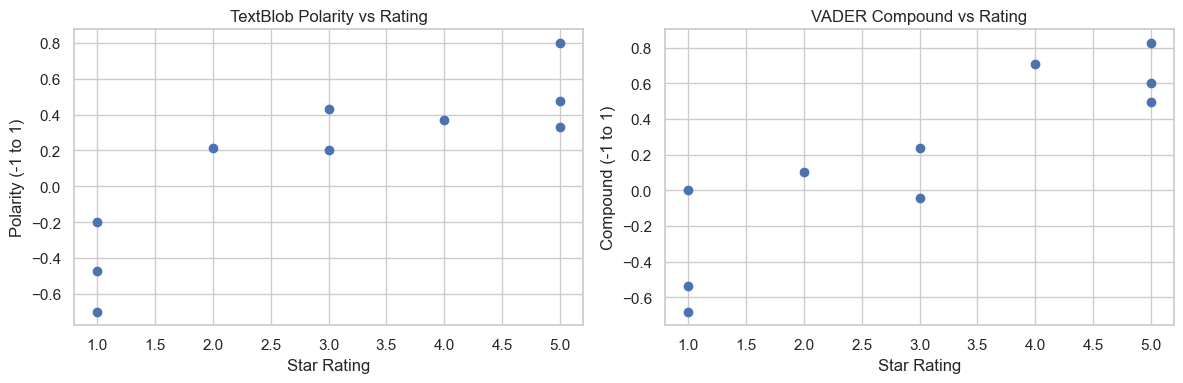

In [12]:
# Cell 13: See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()
